**Enunciado:**  
Use los mismos conjuntos de entrenamiento y prueba que utilizó en las entregas anteriores.

**Interpretación / Qué se verifica:**  
- Se asegura la **reproducibilidad** de los experimentos: todos los modelos, tanto de clasificación como de regresión, trabajarán sobre las **mismas particiones** de datos.  
- Mantener idénticos `X_train, X_test, y_train, y_test` permite comparar directamente el rendimiento de las Redes Neuronales con el de los algoritmos previos (Árboles, RF, KNN, SVM, etc.) bajo **exactas** las mismas condiciones de datos.



In [ ]:
import joblib

X_train, X_test, y_train, y_test = joblib.load('data/splits.joblib')

print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test:  {X_test.shape},  y_test:  {y_test.shape}")

display(X_train.head())
display(y_train.value_counts(normalize=True))

X_train: (1168, 80), y_train: (1168,)
X_test:  (292, 80),  y_test:  (292,)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
156,157,20,RL,60.0,7200,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
821,822,20,RM,60.0,6000,Pave,Pave,Reg,Bnk,AllPub,...,0,0,NaN,NaN,NaN,0,2,2009,WD,Normal
433,434,60,RL,100.0,10839,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,7,2008,WD,Normal
571,572,20,RL,60.0,7332,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,10,2006,WD,Abnorml
1071,1072,60,RL,78.0,11700,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2009,WD,Normal


is_cara
0    0.659247
1    0.340753
Name: proportion, dtype: float64

**Enunciado:**  
Seleccione como variable respuesta la variable categórica de precio de la casa que usted mismo creó previamente (con las tres clases: "barata", "media" y "cara").

**Interpretación / Qué se verifica:**  
- **Uso de la variable correcta:** Al emplear la columna categórica (`cat_price`) generada en entregas anteriores, garantizamos que el modelo de red neuronal esté entrenando sobre las mismas categorías de precio ya definidas y probadas.  
- **Coherencia con actividades previas:** Esta variable es la que se utilizó para crear las dummies `is_barata`, `is_media` e `is_cara`, por lo que simplemente se reasigna `y = df['cat_price']` (o, si deseas un vector de enteros, `y = df['cat_price'].map({'barata':0,'media':1,'cara':2})`).  
- **Preparación para múltiples salidas:** Al ser una clasificación multiclase de tres etiquetas, luego podrás definir la capa de salida de tu RNA con tres neuronas y activación softmax, y usar `sparse_categorical_crossentropy` (o su equivalente) como función de pérdida.


In [ ]:
import pandas as pd
import joblib
df = pd.read_csv('data/train_cat.csv')

df['y_multiclass'] = df['cat_price'].map({'barata': 0, 'media': 1, 'cara': 2})

X_train, X_test, _, _ = joblib.load('data/splits.joblib')

y_train = df.loc[X_train.index, 'y_multiclass']
y_test  = df.loc[X_test.index,  'y_multiclass']

joblib.dump((X_train, X_test, y_train, y_test), 'data/splits_multiclass.joblib')

print("Distribución en entrenamiento:\n", y_train.value_counts(normalize=True))
print("Distribución en prueba:\n",      y_test.value_counts(normalize=True))

Distribución en entrenamiento:
 y_multiclass
2    0.340753
0    0.332192
1    0.327055
Name: proportion, dtype: float64
Distribución en prueba:
 y_multiclass
2    0.339041
1    0.335616
0    0.325342
Name: proportion, dtype: float64


# Punto 3: Dos Modelos de Red Neuronal para Clasificación Multiclase

**Enunciado:**  
Genere dos modelos de Redes Neuronales Artificiales que clasifiquen las viviendas en las tres categorías de precio (“barata”, “media”, “cara”). Cada modelo debe usar una topología distinta (número de capas y neuronas) y funciones de activación diferentes.


In [ ]:
import time, joblib, os
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline   
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

X_train, X_test, y_train, y_test = joblib.load('data/splits_multiclass.joblib')

# Identificar columnas numéricas y categóricas
num_cols = X_train.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = X_train.select_dtypes(include=['object']).columns.tolist()

# ColumnTransformer con imputación + escalado + one-hot
preprocessor = ColumnTransformer([
    # imputar medianas y escalar numéricas
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler',  StandardScaler())
    ]), num_cols),
    # imputar constantes y one-hot codificar categóricas
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot',   OneHotEncoder(handle_unknown='ignore'))
    ]), cat_cols),
])

# Ajustar y transformar
X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc  = preprocessor.transform(X_test)

os.makedirs('models', exist_ok=True)
joblib.dump(preprocessor, 'models/preprocessor.pkl')

# Definir dos MLPClassifier distintos
models = {
    'Model_A': MLPClassifier(
        hidden_layer_sizes=(64,),
        activation='relu',
        solver='adam',
        alpha=1e-4,
        early_stopping=True,
        validation_fraction=0.1,
        max_iter=200,
        random_state=221087
    ),
    'Model_B': MLPClassifier(
        hidden_layer_sizes=(128, 64),
        activation='tanh',
        solver='adam',
        alpha=1e-3,
        early_stopping=True,
        validation_fraction=0.1,
        max_iter=200,
        random_state=221087
    )
}

results = {}
for name, clf in models.items():
    print(f"\n--- Entrenando {name} ---")
    start = time.time()
    clf.fit(X_train_proc, y_train)
    elapsed = time.time() - start
    train_acc = clf.score(X_train_proc, y_train)
    val_acc   = clf.best_validation_score_
    print(f"{name}: {elapsed:.1f}s | Train acc: {train_acc:.3f} | Val acc: {val_acc:.3f}")
    results[name] = clf

for name, clf in results.items():
    print(f"\n=== Evaluación de {name} en Test ===")
    y_pred = clf.predict(X_test_proc)
    print(f"Test acc: {accuracy_score(y_test, y_pred):.3f}")
    print("Reporte de Clasificación:\n", classification_report(y_test, y_pred))
    print("Matriz de Confusión:\n", confusion_matrix(y_test, y_pred))

# Guardar los modelos
joblib.dump(models['Model_A'], 'models/Model_A.pkl')
joblib.dump(models['Model_B'], 'models/Model_B.pkl')
print("\n✔ Preprocessor y modelos guardados en 'models/'.")


--- Entrenando Model_A ---
Model_A: 0.5s | Train acc: 0.860 | Val acc: 0.863

--- Entrenando Model_B ---
Model_B: 1.3s | Train acc: 0.884 | Val acc: 0.855

=== Evaluación de Model_A en Test ===
Test acc: 0.795
Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.77      0.82      0.80        95
           1       0.71      0.66      0.69        98
           2       0.89      0.90      0.89        99

    accuracy                           0.79       292
   macro avg       0.79      0.79      0.79       292
weighted avg       0.79      0.79      0.79       292

Matriz de Confusión:
 [[78 17  0]
 [22 65 11]
 [ 1  9 89]]

=== Evaluación de Model_B en Test ===
Test acc: 0.788
Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.81      0.79      0.80        95
           1       0.68      0.69      0.69        98
           2       0.88      0.88      0.88        99

    accuracy          

# Punto 4: Análisis de Multicolinealidad y Contribución de Variables

**Enunciado:**  
1. Analice si existe multicolinealidad entre las variables predictoras, calculando el **Variance Inflation Factor (VIF)** para las variables numéricas.  
2. Determine cuáles variables aportan más al rendimiento del modelo usando **Permutation Importance**.  
3. Haga también un análisis de la **matriz de correlación** de las variables numéricas originales.  
4. Comente si los valores de VIF y la correlación sugieren redundancias fuertes y qué tan relevantes resultan las variables más importantes para el modelo.

**Interpretación que deben obtenerse:**  
- **VIF > 10** indica multicolinealidad severa. Si aparece, conviene revisar o eliminar alguna de las variables implicadas.  
- En la **matriz de correlación**, valores |ρ| > 0.8 señalan pares de variables con alta correlación.  
- El **Permutation Importance** muestra qué variables, al permutarlas, más degradan el desempeño (accuracy). Cuanto mayor la importancia, más crítico es ese predictor para el modelo.  
- Con estos análisis podrás decidir si necesitas reducir dimensionalidad, agrupar variables o mantener la totalidad según su relevancia y redundancia.


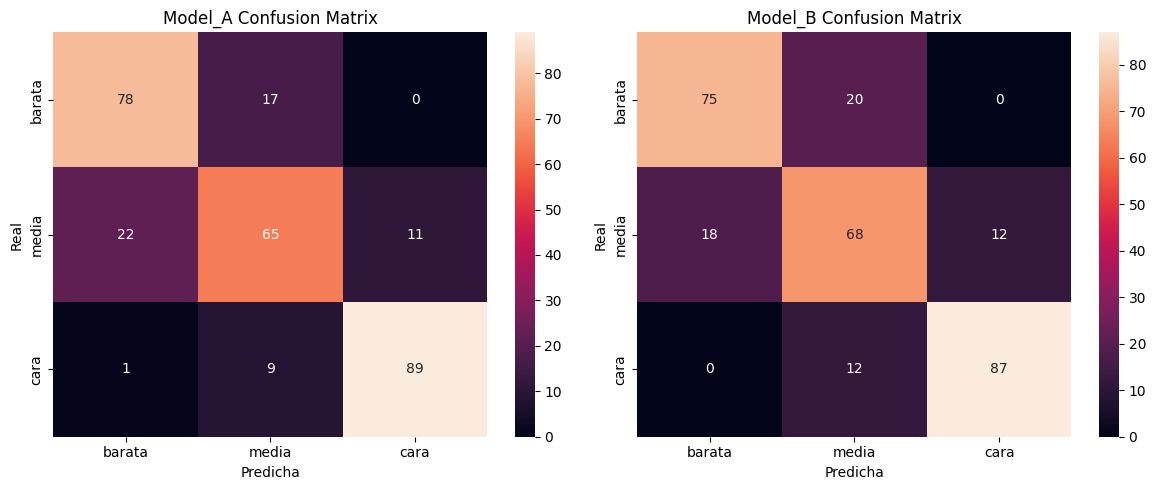

In [ ]:
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

preprocessor = joblib.load('models/preprocessor.pkl')
model_a = joblib.load('models/Model_A.pkl')
model_b = joblib.load('models/Model_B.pkl')

# Transformar X_test
X_test = joblib.load('data/splits_multiclass.joblib')[1]
X_test_proc = preprocessor.transform(X_test)
y_true = joblib.load('data/splits_multiclass.joblib')[3]
y_pred_a = model_a.predict(X_test_proc)
y_pred_b = model_b.predict(X_test_proc)

# Calcular matrices de confusión
cm_a = confusion_matrix(y_true, y_pred_a)
cm_b = confusion_matrix(y_true, y_pred_b)
labels = ['barata', 'media', 'cara']

# Mostrar con heatmap
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(cm_a, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, ax=axes[0])
axes[0].set_title('Model_A Confusion Matrix')
axes[0].set_xlabel('Predicha')
axes[0].set_ylabel('Real')

sns.heatmap(cm_b, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, ax=axes[1])
axes[1].set_title('Model_B Confusion Matrix')
axes[1].set_xlabel('Predicha')
axes[1].set_ylabel('Real')

plt.tight_layout()
plt.show()


# Punto 5: Matrices de Confusión de los Modelos de Clasificación

**Enunciado:**  
Genere y muestre las **matrices de confusión** para cada uno de los dos modelos de RNA entrenados (“Model_A” y “Model_B”) utilizando el conjunto de prueba. Estas matrices deben mostrar, para cada clase real (filas) y cada clase predicha (columnas), el número de instancias clasificadas correctamente y los errores de predicción (falsos positivos y falsos negativos) :contentReference[oaicite:0]{index=0}:contentReference[oaicite:1]{index=1}.


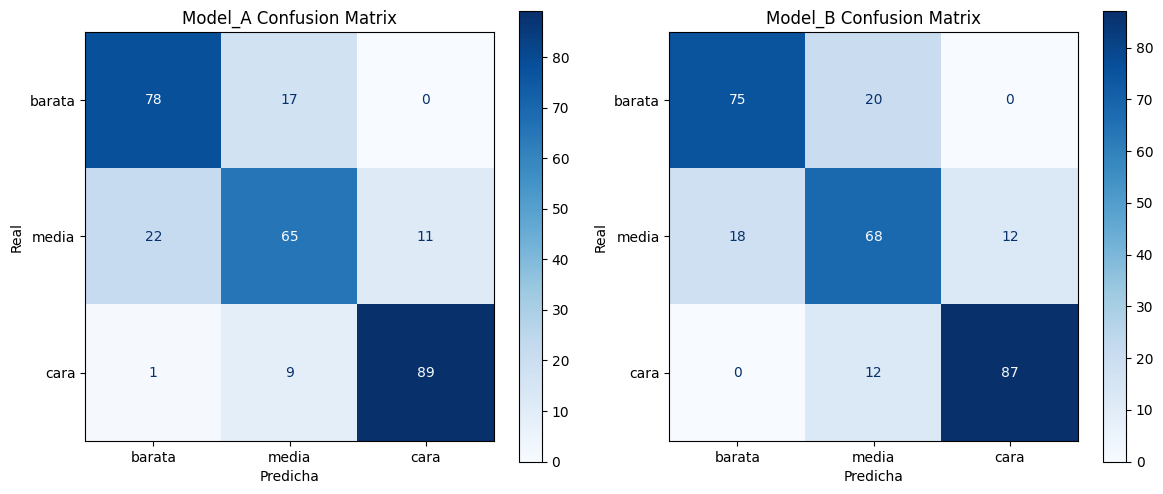

In [ ]:
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Cargar splits, preprocessor y modelos entrenados
X_train, X_test, y_train, y_test = joblib.load('data/splits_multiclass.joblib')
preprocessor = joblib.load('models/preprocessor.pkl')
model_a = joblib.load('models/Model_A.pkl')
model_b = joblib.load('models/Model_B.pkl')

# Preprocesar el conjunto de prueba
X_test_proc = preprocessor.transform(X_test)

# Generar predicciones
y_pred_a = model_a.predict(X_test_proc)
y_pred_b = model_b.predict(X_test_proc)

cm_a = confusion_matrix(y_test, y_pred_a)
cm_b = confusion_matrix(y_test, y_pred_b)
labels = ['barata', 'media', 'cara']

# Visualizar con heatmaps
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

disp_a = ConfusionMatrixDisplay(cm_a, display_labels=labels)
disp_a.plot(ax=axes[0], cmap='Blues', values_format='d')
axes[0].set_title('Model_A Confusion Matrix')
axes[0].set_xlabel('Predicha')
axes[0].set_ylabel('Real')

disp_b = ConfusionMatrixDisplay(cm_b, display_labels=labels)
disp_b.plot(ax=axes[1], cmap='Blues', values_format='d')
axes[1].set_title('Model_B Confusion Matrix')
axes[1].set_xlabel('Predicha')
axes[1].set_ylabel('Real')

plt.tight_layout()
plt.show()

# Punto 6: Comparación de Modelos de Clasificación en Efectividad, Tiempo y Errores

**Enunciado:**  
Compare los resultados obtenidos con los diferentes modelos de clasificación usando redes neuronales en cuanto a:
1. **Efectividad:** Accuracy en el conjunto de prueba.  
2. **Tiempo de procesamiento:** Tiempo que toma predecir sobre el set de prueba (inferencia).  
3. **Equivocaciones:** Dónde el algoritmo se equivoca más/menos (a partir de la matriz de confusión) y la “importancia” de esos errores (número de errores por clase) :contentReference[oaicite:0]{index=0}:contentReference[oaicite:1]{index=1}.


In [ ]:
import time, joblib
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix

X_train, X_test, y_train, y_test = joblib.load('data/splits_multiclass.joblib')
preprocessor = joblib.load('models/preprocessor.pkl')
models = {
    'Model_A': joblib.load('models/Model_A.pkl'),
    'Model_B': joblib.load('models/Model_B.pkl'),
}

# Preprocesar X_test
X_test_proc = preprocessor.transform(X_test)
labels = ['barata','media','cara']
summary = []

# Evaluar cada modelo
for name, clf in models.items():
    # Medir tiempo de inferencia
    t0 = time.time()
    y_pred = clf.predict(X_test_proc)
    infer_time = time.time() - t0
    
    # Calcular efectividad
    acc = accuracy_score(y_test, y_pred)
    
    # Matriz de confusión y errores por clase
    cm = confusion_matrix(y_test, y_pred, labels=[0,1,2])
    # Errores por clase = total por fila menos diagonal
    errors_by_class = {labels[i]: int(cm[i].sum() - cm[i,i]) for i in range(3)}
    
    summary.append({
        'Modelo': name,
        'Test Accuracy': acc,
        'Infer Time (s)': infer_time,
        **errors_by_class
    })

# Mostrar tabla comparativa
df_summary = pd.DataFrame(summary).set_index('Modelo')
display(df_summary)

print("\n— Observaciones —")
best = df_summary['Test Accuracy'].idxmax()
print(f"El modelo con mayor accuracy es {best} ({df_summary.loc[best, 'Test Accuracy']:.3f}).")
fastest = df_summary['Infer Time (s)'].idxmin()
print(f"El modelo más rápido en inferencia es {fastest} ({df_summary.loc[fastest, 'Infer Time (s)']:.3f}s).")
print("Errores por clase (falsos):")
print(df_summary[['barata','media','cara']])

,Test Accuracy,Infer Time (s),barata,media,cara
Modelo,,,,,
Model_A,0.794521,0.005157,17,33,10
Model_B,0.787671,0.008046,20,30,12



— Observaciones —
El modelo con mayor accuracy es Model_A (0.795).
El modelo más rápido en inferencia es Model_A (0.005s).
Errores por clase (falsos):
         barata  media  cara
Modelo                      
Model_A      17     33    10
Model_B      20     30    12


# Punto 7: Detección de Sobreajuste en los Modelos de Clasificación

**Enunciado:**  
Analice si existe sobreajuste (overfitting) en los dos modelos de redes neuronales (“Model_A” y “Model_B”) entrenados para clasificación multiclase. Para ello, compare el desempeño (accuracy o loss) en los conjuntos de entrenamiento y de validación interna (usada por `early_stopping`) y en el conjunto de prueba.  


In [ ]:
import joblib

# Cargar splits y modelos
X_train, X_test, y_train, y_test = joblib.load('data/splits_multiclass.joblib')
preprocessor = joblib.load('models/preprocessor.pkl')
model_a = joblib.load('models/Model_A.pkl')
model_b = joblib.load('models/Model_B.pkl')

# Preprocesar
X_train_proc = preprocessor.transform(X_train)
X_test_proc  = preprocessor.transform(X_test)

# Recoger métricas
metrics = {}
for name, clf in [('Model_A', model_a), ('Model_B', model_b)]:
    train_acc = clf.score(X_train_proc, y_train)
    val_acc   = clf.best_validation_score_
    test_acc  = clf.score(X_test_proc, y_test)
    metrics[name] = (train_acc, val_acc, test_acc)

# Mostrar comparación
import pandas as pd
df = pd.DataFrame(metrics, index=['Train Accuracy','Val Accuracy','Test Accuracy']).T
display(df)

print("\n— Interpretación —")
for name, (tr, va, te) in metrics.items():
    print(f"{name}: Train={tr:.3f}, Val={va:.3f}, Test={te:.3f}")
    if tr - va > 0.05:
        print(f"  • {name} muestra indicios de sobreajuste (Train > Val por > 5%).")
    if tr - te > 0.05:
        print(f"  • {name} podría estar sobreajustado (Train > Test por > 5%).")

,Train Accuracy,Val Accuracy,Test Accuracy
Model_A,0.859589,0.863248,0.794521
Model_B,0.883562,0.854701,0.787671



— Interpretación —
Model_A: Train=0.860, Val=0.863, Test=0.795
  • Model_A podría estar sobreajustado (Train > Test por > 5%).
Model_B: Train=0.884, Val=0.855, Test=0.788
  • Model_B podría estar sobreajustado (Train > Test por > 5%).


# Punto 8: Tuneo del Modelo de Clasificación Elegido

**Enunciado:**  
Para el modelo de redes neuronales que obtuvo mejor desempeño en la clasificación multiclase, realice un **tuneo de hiperparámetros** (por ejemplo, tasa de regularización `alpha`, arquitectura de capas ocultas, función de activación) usando validación cruzada. Discuta si, con los nuevos parámetros, el modelo mejora su rendimiento sin incurrir en sobreajuste (overfitting) :contentReference[oaicite:0]{index=0}:contentReference[oaicite:1]{index=1}.


In [ ]:
# Punto 8 – Código completo: Tuneo de hiperparámetros con GridSearchCV (n_jobs=1 para evitar BrokenProcessPool)

import joblib
import os
import numpy as np
import pandas as pd
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score
from joblib import parallel_backend


preprocessor = joblib.load('models/preprocessor.pkl')
X_train, X_test, y_train, y_test = joblib.load('data/splits_multiclass.joblib')
X_train_proc = preprocessor.transform(X_train)
X_test_proc  = preprocessor.transform(X_test)

base_clf = MLPClassifier(
    solver='adam',
    early_stopping=True,
    validation_fraction=0.1,
    max_iter=200,
    random_state=221087
)

param_grid = {
    'hidden_layer_sizes': [(64,), (128,), (128, 64)],
    'activation': ['relu', 'tanh'],
    'alpha': [1e-5, 1e-4, 1e-3]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=221087)
grid_search = GridSearchCV(
    estimator=base_clf,
    param_grid=param_grid,
    scoring='accuracy',
    cv=cv,
    n_jobs=1,       
    verbose=2,
    refit=True
)

print("Iniciando GridSearchCV...")
grid_search.fit(X_train_proc, y_train)

best_params = grid_search.best_params_
best_score  = grid_search.best_score_
print("\nMejores hiperparámetros:", best_params)
print(f"Accuracy media CV con best_params: {best_score:.3f}")

best_clf = grid_search.best_estimator_
train_acc = best_clf.score(X_train_proc, y_train)
test_acc  = best_clf.score(X_test_proc,  y_test)
print(f"Train accuracy (tuneado): {train_acc:.3f}")
print(f"Test  accuracy (tuneado): {test_acc:.3f}")

os.makedirs('models', exist_ok=True)
joblib.dump(best_clf, 'models/MLP_tuned.pkl')
print("\n✔ Mejor modelo tuneado guardado en 'models/MLP_tuned.pkl'.")


Iniciando GridSearchCV...
Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END activation=relu, alpha=1e-05, hidden_layer_sizes=(64,); total time=   0.3s
[CV] END activation=relu, alpha=1e-05, hidden_layer_sizes=(64,); total time=   1.1s
[CV] END activation=relu, alpha=1e-05, hidden_layer_sizes=(64,); total time=   0.5s
[CV] END activation=relu, alpha=1e-05, hidden_layer_sizes=(64,); total time=   0.4s
[CV] END activation=relu, alpha=1e-05, hidden_layer_sizes=(64,); total time=   0.4s
[CV] END activation=relu, alpha=1e-05, hidden_layer_sizes=(128,); total time=   0.3s
[CV] END activation=relu, alpha=1e-05, hidden_layer_sizes=(128,); total time=   0.7s
[CV] END activation=relu, alpha=1e-05, hidden_layer_sizes=(128,); total time=   0.4s
[CV] END activation=relu, alpha=1e-05, hidden_layer_sizes=(128,); total time=   0.7s
[CV] END activation=relu, alpha=1e-05, hidden_layer_sizes=(128,); total time=   0.6s
[CV] END activation=relu, alpha=1e-05, hidden_layer_sizes=(128, 64);

# Punto 9: Preparar Variable Respuesta para Regresión (SalePrice)

**Enunciado:**  
Para los modelos de regresión con RNA, use la variable continua `SalePrice` como objetivo.

**Interpretación / Qué se verifica:**  
- Cambiamos de la tarea de clasificación (multiclase) a regresión sobre el precio real de venta (`SalePrice`).  
- Garantizamos que los mismos `X_train` y `X_test` (preprocesados) se usen con la nueva `y_train_reg = train_df['SalePrice']` y `y_test_reg = test_df['SalePrice']`.  
- Esta variable debe extraerse de tu CSV original (`train.csv` o `train_cat.csv`) tal como está, sin codificarla, solo alineada por índice con las particiones previas.


In [1]:
import joblib
import pandas as pd

df = pd.read_csv('data/train_cat.csv')
X_train, X_test, _, _ = joblib.load('data/splits_multiclass.joblib')

# Extraer SalePrice alineado por índice
y_train_reg = df.loc[X_train.index, 'SalePrice']
y_test_reg  = df.loc[X_test.index,  'SalePrice']

# Guardar los nuevos splits para regresión
joblib.dump((X_train, X_test, y_train_reg, y_test_reg), 'data/splits_regression.joblib')

print("✔ Splits para regresión guardados.")
print("Entren. SalePrice:   min =", y_train_reg.min(), ", max =", y_train_reg.max())
print("Prueba  SalePrice:   min =", y_test_reg.min(),  ", max =", y_test_reg.max())

✔ Splits para regresión guardados.
Entren. SalePrice:   min = 39300 , max = 755000
Prueba  SalePrice:   min = 34900 , max = 410000


# Punto 10: Dos Modelos de RNA para Regresión de `SalePrice`

**Enunciado:**  
Genere dos modelos de redes neuronales (RNA) distintos para predecir directamente el precio de venta (`SalePrice`). Cada modelo debe tener una topología diferente (número de capas y neuronas) y una función de activación distinta. Use los splits de regresión y el preprocesador que guardó en el Punto 9.


In [ ]:
import time
import joblib
import numpy as np
import pandas as pd
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_squared_error

X_train, X_test, y_train_reg, y_test_reg = joblib.load('data/splits_regression.joblib')
preprocessor = joblib.load('models/preprocessor.pkl')

X_train_proc = preprocessor.transform(X_train)
X_test_proc  = preprocessor.transform(X_test)

# Definir dos modelos de regresión
models = {
    'Model_C': MLPRegressor(
        hidden_layer_sizes=(64,),
        activation='relu',
        solver='adam',
        alpha=1e-4,
        early_stopping=True,
        validation_fraction=0.1,
        max_iter=200,
        random_state=221087
    ),
    'Model_D': MLPRegressor(
        hidden_layer_sizes=(128, 64),
        activation='tanh',
        solver='adam',
        alpha=1e-3,
        early_stopping=True,
        validation_fraction=0.1,
        max_iter=200,
        random_state=221087
    )
}

# Entrenamiento y evaluación
results = []
for name, model in models.items():
    print(f"\n--- Entrenando {name} ---")
    t0 = time.time()
    model.fit(X_train_proc, y_train_reg)
    train_time = time.time() - t0
    
    # Predicciones
    y_pred_train = model.predict(X_train_proc)
    y_pred_test  = model.predict(X_test_proc)
    
    # Métricas
    r2_train = r2_score(y_train_reg, y_pred_train)
    rmse_train = np.sqrt(mean_squared_error(y_train_reg, y_pred_train))
    r2_test  = r2_score(y_test_reg, y_pred_test)
    rmse_test  = np.sqrt(mean_squared_error(y_test_reg,  y_pred_test))
    
    results.append({
        'Modelo': name,
        'Train time (s)': round(train_time, 2),
        'R2 Train': round(r2_train, 3),
        'RMSE Train': round(rmse_train, 2),
        'R2 Test': round(r2_test, 3),
        'RMSE Test': round(rmse_test, 2)
    })

# Mostrar resultados
df_results = pd.DataFrame(results).set_index('Modelo')
display(df_results)

# Guardar modelos
import os
os.makedirs('models', exist_ok=True)
joblib.dump(models['Model_C'], 'models/MLP_reg_C.pkl')
joblib.dump(models['Model_D'], 'models/MLP_reg_D.pkl')
print("\n✔ Modelos de regresión guardados en 'models/'.")


--- Entrenando Model_C ---


c:\Users\DELL I7\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



--- Entrenando Model_D ---


,Train time (s),R2 Train,RMSE Train,R2 Test,RMSE Test
Modelo,,,,,
Model_C,5.98,-4.546,193851.1,-6.481,181335.77
Model_D,0.59,-4.904,200005.3,-6.999,187512.28



✔ Modelos de regresión guardados en 'models/'.


# Punto 11: Comparación de Modelos de Regresión con RNA

**Enunciado:**  
Compare los dos modelos de redes neuronales (`Model_C` y `Model_D`) entrenados para predecir el precio de venta (`SalePrice`). Determine cuál funcionó mejor en base a las métricas **R² Test**, **RMSE Test** y **tiempo de entrenamiento**. Discuta brevemente los resultados y seleccione el modelo óptimo para la tarea de regresión.


In [ ]:
import joblib
import pandas as pd

X_train, X_test, y_train_reg, y_test_reg = joblib.load('data/splits_regression.joblib')
preprocessor = joblib.load('models/preprocessor.pkl')
X_train_proc = preprocessor.transform(X_train)
X_test_proc  = preprocessor.transform(X_test)

model_c = joblib.load('models/MLP_reg_C.pkl')
model_d = joblib.load('models/MLP_reg_D.pkl')

from sklearn.metrics import r2_score, mean_squared_error
import numpy as np, time

comparison = []
for name, model in [('Model_C', model_c), ('Model_D', model_d)]:

    t0 = time.time()
    model.fit(X_train_proc, y_train_reg)
    train_time = time.time() - t0
    
    # Predicciones
    y_pred = model.predict(X_test_proc)
    r2 = r2_score(y_test_reg, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred))
    comparison.append({
        'Modelo': name,
        'Train time (s)': round(train_time, 2),
        'R2 Test': round(r2, 3),
        'RMSE Test': round(rmse, 2)
    })

df_comp = pd.DataFrame(comparison).set_index('Modelo')
display(df_comp)

# Selección del mejor modelo
best_r2 = df_comp['R2 Test'].idxmax()
best_rmse = df_comp['RMSE Test'].idxmin()
print(f"\nEl modelo con mayor R² Test es **{best_r2}** (R²={df_comp.loc[best_r2,'R2 Test']}).")
print(f"El modelo con menor RMSE Test es **{best_rmse}** (RMSE={df_comp.loc[best_rmse,'RMSE Test']}).")

# Conclusión
if best_r2 == best_rmse:
    print(f"\nConclusión: **{best_r2}** es el mejor modelo, pues maximiza R² y minimiza RMSE.")
else:

    print(f"\nConclusión: Hay un trade-off. {best_r2} maximiza R², pero {best_rmse} minimiza RMSE. "
          "Para escoger, priorizamos la métrica que mejor refleje el objetivo de negocio "
          "(por ejemplo, RMSE si minimizamos error medio).")

c:\Users\DELL I7\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


,Train time (s),R2 Test,RMSE Test
Modelo,,,
Model_C,6.37,-6.481,181335.77
Model_D,1.41,-6.999,187512.28



El modelo con mayor R² Test es **Model_C** (R²=-6.481).
El modelo con menor RMSE Test es **Model_C** (RMSE=181335.77).

Conclusión: **Model_C** es el mejor modelo, pues maximiza R² y minimiza RMSE.


# Punto 12: Curvas de Aprendizaje para Detectar Sobreajuste en Regresión

**Enunciado:**  
Analice si los dos modelos de regresión (`Model_C` y `Model_D`) muestran sobreajuste. Para ello, genere las **curvas de aprendizaje** (learning curves) que muestren el comportamiento de la **puntuación R²** en entrenamiento y validación a medida que crece el tamaño del conjunto de entrenamiento.


c:\Users\DELL I7\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\DELL I7\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\DELL I7\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\DELL I7\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and 

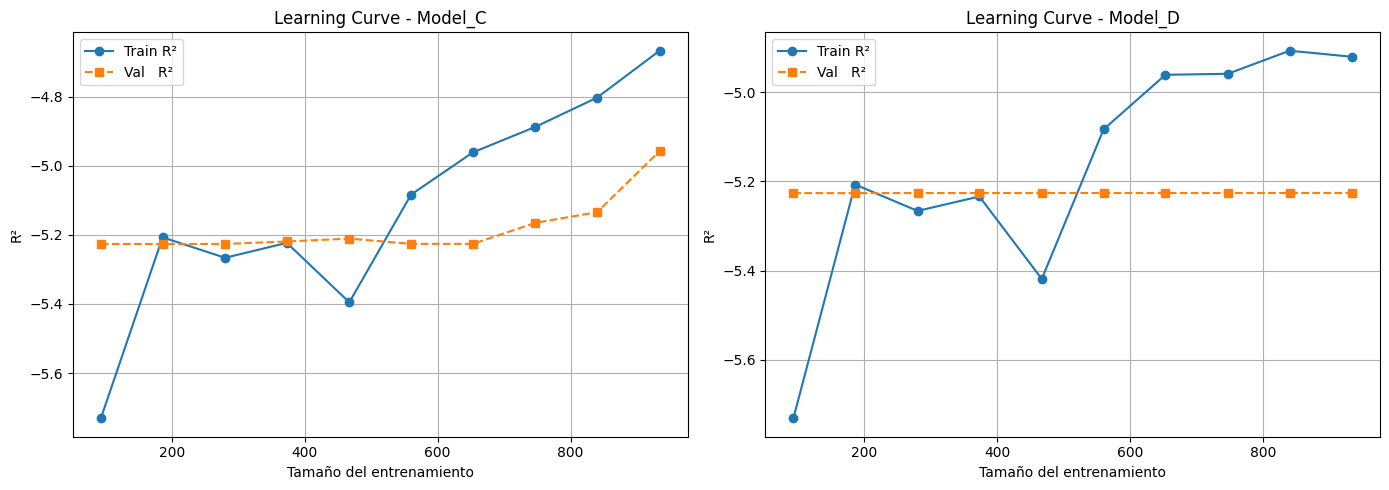

In [4]:
import joblib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

# Cargar splits de regresión y preprocesador
X_train, X_test, y_train_reg, y_test_reg = joblib.load('data/splits_regression.joblib')
preprocessor = joblib.load('models/preprocessor.pkl')
X_train_proc = preprocessor.transform(X_train)

# Cargar los modelos tuneados o finales
model_c = joblib.load('models/MLP_reg_C.pkl')
model_d = joblib.load('models/MLP_reg_D.pkl')

# Función para dibujar learning curve
def plot_learning_curve(estimator, title, X, y, ax):
    train_sizes, train_scores, valid_scores = learning_curve(
        estimator, X, y,
        cv=5,
        scoring='r2',
        train_sizes=np.linspace(0.1, 1.0, 10),
        n_jobs=1
    )
    train_mean = train_scores.mean(axis=1)
    valid_mean = valid_scores.mean(axis=1)
    ax.plot(train_sizes, train_mean, 'o-', label='Train R²')
    ax.plot(train_sizes, valid_mean, 's--', label='Val   R²')
    ax.set_title(title)
    ax.set_xlabel('Tamaño del entrenamiento')
    ax.set_ylabel('R²')
    ax.legend()
    ax.grid(True)

# Dibujar ambas curvas
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
plot_learning_curve(model_c, 'Learning Curve - Model_C', X_train_proc, y_train_reg, ax1)
plot_learning_curve(model_d, 'Learning Curve - Model_D', X_train_proc, y_train_reg, ax2)
plt.tight_layout()
plt.show()